# 学習済みモデルを利用する 

## 概要
- 分子の構造を示す[SMILES](https://ja.wikipedia.org/wiki/SMILES%E8%A8%98%E6%B3%95)を入力すると結合解離エネルギー（BDE）を予測するプログラムを作成する。
- 予測には`1_training.ipynb`で作成した学習済みモデル`model/estimate_single_bond_bde.json`を使用する。
- 学習データとして「単結合」かつ「環状構造に含まれない結合」のBDEしか与えていないため、その他の結合についてはBDEを出力しない。
### 流れ
1. 入力されたSMILESの分子内の結合の特徴量を計算する。
2. 学習済みモデル`model/estimate_single_bond_bde.json`をロードする
3. 1を2のインプットとして、BDEを予測する。

In [1]:
import subprocess
from PIL import Image, ImageDraw, ImageFont
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import xgboost as xgb

In [2]:
# 単結合の結合解離エネルギー（BDE）を予測する分子のSMILES
# C, H, N, O以外の元素を含めると計算できません。
smiles = 'CN1CCC[C@H]1c2cccnc2'
mol = Chem.MolFromSmiles(smiles)
if mol is None:
    raise ValueError(f"入力されたSMILESは不適切です: {smiles}")

In [3]:
for atom in mol.GetAtoms():
    if atom.GetSymbol() not in ['C', 'H', 'N', 'O']:
        contains_other_elements = True
        raise ValueError(f"分子にはC, H, N, O以外の元素が含まれています: {atom.GetSymbol()}")

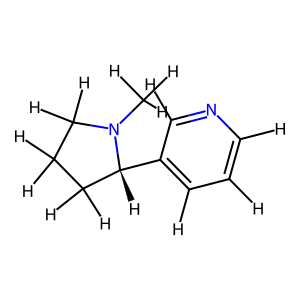

In [4]:
# 分子を取得し、水素を明示して描画
mol_with_h = Chem.AddHs(mol)
Draw.MolToImage(mol_with_h)

In [5]:
# 分子内の結合の情報を取得
bond_info = {
    "id" : [],
    "elements": [],
    "bond_type": [],
    "is_ring": [],
    "fragments" : [],
}
for bond in mol_with_h.GetBonds():
    id = bond.GetIdx()
    elements = (bond.GetBeginAtom().GetSymbol(), bond.GetEndAtom().GetSymbol())
    bond_type = str(bond.GetBondType())
    is_ring = bond.IsInRing()

    # 結合が単結合かつ環状構造じゃないときに、結合を解離してフラグメントを生成
    if bond_type == "SINGLE" and not is_ring:
        fragment_mol = Chem.FragmentOnBonds(mol_with_h, [bond.GetIdx()])
        fragments = tuple(Chem.MolToSmiles(fragment_mol).split("."))
    else:
        fragments = (None, None)

    
    bond_info["id"].append(id)
    bond_info["elements"].append(elements)
    bond_info["bond_type"].append(bond_type)
    bond_info["is_ring"].append(is_ring)
    bond_info["fragments"].append(fragments)

df_bond_info = pd.DataFrame(bond_info)
df_bond_info

,id,elements,bond_type,is_ring,fragments
0,0,"(C, N)",SINGLE,False,(*N1C([H])([H])C([H])([H])C([H])([H])[C@@]1([H...
1,1,"(N, C)",SINGLE,True,"(None, None)"
2,2,"(C, C)",SINGLE,True,"(None, None)"
3,3,"(C, C)",SINGLE,True,"(None, None)"
4,4,"(C, C)",SINGLE,True,"(None, None)"
5,5,"(C, C)",SINGLE,False,"([5*]c1c([H])nc([H])c([H])c1[H], [6*][C@@]1([H..."
6,6,"(C, C)",AROMATIC,True,"(None, None)"
7,7,"(C, C)",AROMATIC,True,"(None, None)"
8,8,"(C, C)",AROMATIC,True,"(None, None)"
9,9,"(C, N)",AROMATIC,True,"(None, None)"


In [6]:
type(mol)

rdkit.Chem.rdchem.Mol

In [7]:
def calc_bond_descriptor(mol: Chem.rdchem.Mol):
    """
    分子の各結合を表現する特徴量を計算する。
    """
    bond_descriptors_list = []
    jar_path = 'bin/TypePairBondDescriptor.jar'
    sdf_file = f'data/mol.sdf'
    w = Chem.SDWriter(sdf_file)
    w.write(mol)
    w.close()
    command = ["java", "-jar", jar_path, "compact", "All", sdf_file, "true"]
    result = subprocess.run(command, capture_output=True, text=True)
    for i, line in enumerate(result.stdout.split('\n')):
        bond_descriptors = {
            "id": i,
            "descriptors": [int(v) for v in line.split()]
        }
        if len(bond_descriptors["descriptors"]) == 131:
            bond_descriptors_list.append(bond_descriptors)
    
    return bond_descriptors_list

In [8]:
# 分子に含まれる各結合の特徴量を計算
bond_descriptors_list = calc_bond_descriptor(mol)

In [9]:
# pandasのDataFrame化
df_descriptor = pd.DataFrame([[dict['id'], *dict['descriptors']] for dict in bond_descriptors_list])
df_descriptor

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,0,1,2,0,0,1,0,0,0,1,...,0,26,0,28,0,0,14,0,1,2
1,1,2,3,0,0,1,0,0,0,1,...,6,20,0,28,0,0,14,0,1,2
2,2,3,4,0,0,2,0,0,0,0,...,0,12,0,0,0,0,0,0,0,1
3,3,4,5,0,0,2,0,0,0,0,...,0,8,0,28,0,0,14,0,1,2
4,4,5,6,0,0,2,0,0,0,0,...,4,42,28,10,0,14,5,1,2,2
5,5,6,7,0,1,1,0,0,0,0,...,20,33,38,3,14,5,0,2,2,1
6,6,7,8,0,2,0,0,0,0,0,...,7,21,13,28,5,14,0,2,2,0
7,7,8,9,0,2,0,0,0,0,0,...,1,7,3,10,0,5,14,2,2,0
8,8,9,10,0,2,0,0,0,0,0,...,0,2,0,3,0,0,5,2,2,0
9,9,10,11,0,1,0,0,0,1,0,...,1,1,0,3,0,0,5,2,2,0


In [10]:
# 予測に使用しない列を削除
unused_columns = [
    0, 1, 2, 7, 10, 11, 13, 14, 15, 16, 21, 24, 27, 28, 29, 30, 38,
    41, 42, 43, 44, 52, 55, 56, 57, 58, 63, 67, 70, 71, 72,
    73, 78, 82, 85, 86, 87, 88, 93, 97, 100, 101, 102, 103, 110
]
df_descriptor.drop(columns = unused_columns, inplace=True)
df_descriptor

,3,4,5,6,8,9,12,17,18,19,...,122,123,124,125,126,127,128,129,130,131
0,0,0,1,0,0,1,0,0,0,2,...,0,26,0,28,0,0,14,0,1,2
1,0,0,1,0,0,1,0,0,0,3,...,6,20,0,28,0,0,14,0,1,2
2,0,0,2,0,0,0,0,0,0,1,...,0,12,0,0,0,0,0,0,0,1
3,0,0,2,0,0,0,0,0,0,2,...,0,8,0,28,0,0,14,0,1,2
4,0,0,2,0,0,0,0,0,1,1,...,4,42,28,10,0,14,5,1,2,2
5,0,1,1,0,0,0,0,0,2,1,...,20,33,38,3,14,5,0,2,2,1
6,0,2,0,0,0,0,0,0,2,1,...,7,21,13,28,5,14,0,2,2,0
7,0,2,0,0,0,0,0,0,2,0,...,1,7,3,10,0,5,14,2,2,0
8,0,2,0,0,0,0,0,0,1,0,...,0,2,0,3,0,0,5,2,2,0
9,0,1,0,0,1,0,0,0,2,0,...,1,1,0,3,0,0,5,2,2,0


In [11]:
# 「単結合」かつ「環状構造に含まれない結合」のIDを取得
condition = (df_bond_info['bond_type'] == 'SINGLE') & (~df_bond_info['is_ring'])
idxs = df_bond_info.index[condition].tolist()
idxs

[0, 5, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

In [12]:
# 予測に使用する特徴量
df_pred = df_descriptor.iloc[idxs]
df_pred

,3,4,5,6,8,9,12,17,18,19,...,122,123,124,125,126,127,128,129,130,131
0,0,0,1,0,0,1,0,0,0,2,...,0,26,0,28,0,0,14,0,1,2
5,0,1,1,0,0,0,0,0,2,1,...,20,33,38,3,14,5,0,2,2,1
13,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16,0,0,1,1,0,0,0,0,0,1,...,0,12,0,0,0,0,0,0,0,1
17,0,0,1,1,0,0,0,0,0,1,...,0,12,0,0,0,0,0,0,0,1
18,0,0,1,1,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
19,0,0,1,1,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
20,0,0,1,1,0,0,0,0,0,2,...,0,8,0,28,0,0,14,0,1,2


In [13]:
# 結合解離エネルギーを予測するモデルをロード
model = xgb.Booster()
model.load_model('model/estimate_single_bond_bde.json')

In [14]:
# 結合解離エネルギーを予測
pred = model.predict(xgb.DMatrix(df_pred))
id_bde = {k: round(float(v), 2) for k, v in zip(idxs, pred)}
id_bde

{0: 80.42,
 5: 97.7,
 13: 91.59,
 14: 91.59,
 15: 91.59,
 16: 91.38,
 17: 91.38,
 18: 96.75,
 19: 96.75,
 20: 96.59,
 21: 96.59,
 22: 82.91,
 23: 110.48,
 24: 110.96,
 25: 106.46,
 26: 105.04}

In [15]:
# 結合情報にBDEを追加
def add_row_bde(row):
    key = row['id']
    bde = None
    if key in id_bde.keys():
        bde = id_bde[row['id']]
    return bde
df_bond_info['BDE'] = df_bond_info.apply(add_row_bde, axis=1)
df_bond_info

,id,elements,bond_type,is_ring,fragments,BDE
0,0,"(C, N)",SINGLE,False,(*N1C([H])([H])C([H])([H])C([H])([H])[C@@]1([H...,80.42
1,1,"(N, C)",SINGLE,True,"(None, None)",NaN
2,2,"(C, C)",SINGLE,True,"(None, None)",NaN
3,3,"(C, C)",SINGLE,True,"(None, None)",NaN
4,4,"(C, C)",SINGLE,True,"(None, None)",NaN
5,5,"(C, C)",SINGLE,False,"([5*]c1c([H])nc([H])c([H])c1[H], [6*][C@@]1([H...",97.70
6,6,"(C, C)",AROMATIC,True,"(None, None)",NaN
7,7,"(C, C)",AROMATIC,True,"(None, None)",NaN
8,8,"(C, C)",AROMATIC,True,"(None, None)",NaN
9,9,"(C, N)",AROMATIC,True,"(None, None)",NaN
